In [38]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [39]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [40]:
from compute import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
ctx = cl.create_some_context()

In [127]:
class Scene:
    def __init__(self, ctx, size, samples=2):
        self.context = ctx
        self.size = size
        self.shape = (size[1], size[0])
        
        self.samples = samples
        self.upsize = [s*self.samples for s in size]
        self.upshape = (self.upsize[1], self.upsize[0])
        
        self.queue = cl.CommandQueue(ctx)
        with open("compute.cl", "r") as f:
            self.program = cl.Program(self.context, f.read()).build()
        
        self.depth_img = Image2D(
            self.context,
            np.zeros(self.upshape, dtype=np.float32),
            fmt=cl.ImageFormat(cl.channel_order.R, cl.channel_type.FLOAT)
        )
        
        self.color_img = Image2D(
            self.context,
            np.zeros((*self.shape, 4), dtype=np.float32), 
            rw=cl.mem_flags.WRITE_ONLY, 
            fmt=cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT),
        )
        
    def compute(self, pos, zoom, depth=0x100):
        self.program.compute(
            self.queue,
            self.upsize,
            None,
            self.depth_img.buf,
            np.array(pos, dtype=np.float32),
            np.array([zoom], dtype=np.float32),
            np.array([depth], dtype=np.int32),
            np.array([0], dtype=np.int32), np.array([0,0], dtype=np.float32),
        )
        self.depth_img.load(self.queue)
        return self.depth_img.host
    
    def colorize(self, colors, period=1.0):
        color_map = Image1D(
            self.context,
            np.array(colors, dtype=np.float32),
            fmt=cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT)
        )
        self.program.colorize(
            self.queue,
            self.size,
            None,
            self.depth_img.buf,
            self.color_img.buf,
            np.array([self.samples], dtype=np.int32),
            color_map.buf,
            np.array([period], dtype=np.float32)
        )
        self.color_img.load(self.queue)
        return self.color_img.host

In [135]:
scene = Scene(ctx, (512, 256))

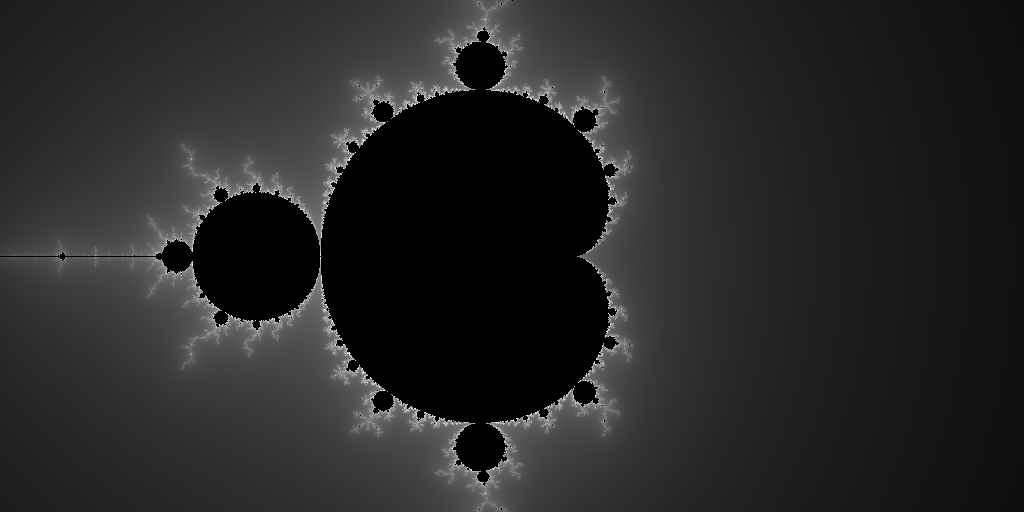

In [136]:
max_depth = 1024
depth_buffer = scene.compute((0, 0), 2, depth=max_depth)
display(Image.fromarray((255*np.log(np.maximum(depth_buffer, 0) + 1)/np.log(max_depth)).astype(np.uint8)))

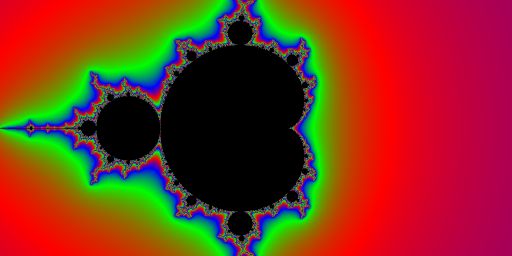

In [137]:
color_buffer = scene.colorize([[1,0,0,1], [0,1,0,1], [0,0,1,1]], period=10)
display(Image.fromarray((255*color_buffer).astype(np.uint8)))